## 毒品資料為基礎建立隨機森林模型
1. 不處理資料不平衡分佈
2. 超參數調教
3. 計算效能指標
4. ROC_AUC Curve
5. factor importance
6. confusion matrix

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

In [40]:
plt.rcParams['font.sans-serif']=['Microsoft Jhenghei']
plt.rcParams['axes.unicode_minus']=False

### 資料讀取

In [41]:
df = pd.read_csv("../data/traindrug.csv", encoding="utf8")

In [42]:
df.shape

(65402, 16)

([0, 1], [Text(0, 0, ''), Text(0, 0, '')])

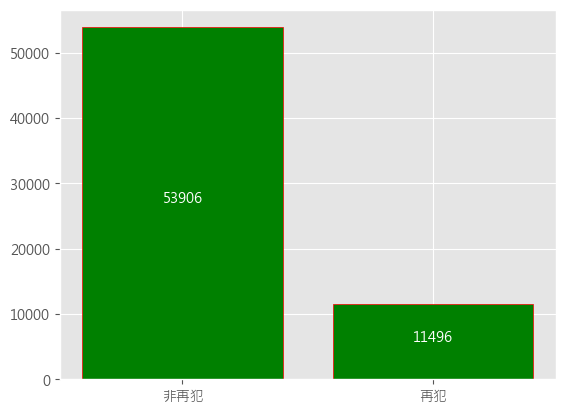

In [43]:
d1 = df['再犯註記'].value_counts()[0]
d2 = df['再犯註記'].value_counts()[1]
barplot=plt.bar(["非再犯", "再犯"], df['再犯註記'].value_counts(), fc="green", ec="red")
plt.bar_label(barplot, labels=df['再犯註記'].value_counts(), label_type="center", color='white', padding=3)
plt.xticks(rotation=0)

Text(0.5, 0, '再犯註記(1:再犯，0:非再犯)')

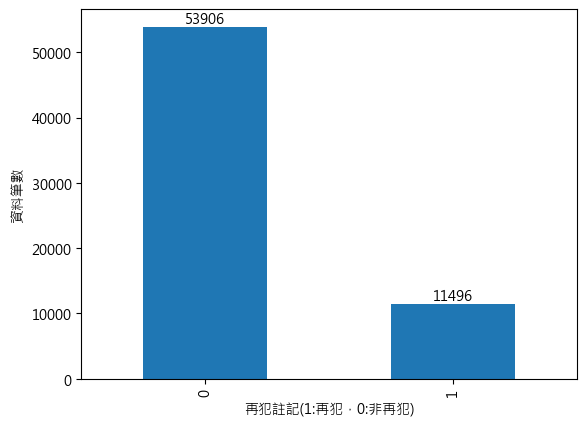

In [7]:
tgtn = df.groupby('再犯註記')
ax = tgtn.size().plot.bar()
ax.bar_label(ax.containers[0]) #顯示bar的資料數據 
ax.set_ylabel("資料筆數") #設定y軸標籤
ax.set_xlabel("再犯註記(1:再犯，0:非再犯)") #設定y軸標籤

### 建立訓練集與測試集(X, y)

In [44]:
#X = df.drop(labels=['再犯註記'], axis=1).values
#y = df['再犯註記'].values
X = df.drop(labels=['再犯註記'], axis=1)
y = df['再犯註記']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 超參數調教

In [9]:
# Import Random Forest model
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(class_weight="balanced", random_state = 42)

In [11]:
rf.get_params() #get default params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### design of param grid

In [46]:
n_estimators = np.arange(100, 2000, step=200)
max_features = ["auto", "sqrt", "log2"]
max_depth = np.arange(2, 100, step=10)
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [1, 2, 3, 4, 5]
bootstrap = [True, False]

In [47]:
param_grid={
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

### random search for hyperparameters

In [48]:
from sklearn.model_selection import RandomizedSearchCV
forest = RandomForestClassifier(class_weight="balanced_subsample", random_state = 42)
rand_cv = RandomizedSearchCV(forest, param_grid, n_iter=100, cv=5, scoring="roc_auc", n_jobs=-1)

在機器學習模型中，需要人工選擇的參數稱爲超參數。

In [49]:
rand_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 2, 12, 22, 32, 42, 52, 62, 72, 82, 92]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': array([2, 4, 6, 8]),
                                        'n_estimators': array([ 100,  300,  500,  700,  900, 1100, 1300, 1500, 1700, 1900])},
                   scoring='roc_auc')

In [50]:
rand_cv.best_score_

0.7843464451073848

In [51]:
print(rand_cv.best_params_) # obtain params by random search

{'n_estimators': 1700, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 22, 'bootstrap': True}


In [61]:
new_params = {
    "n_estimators": [1600, 1650, 1700, 1750, 1800],
    "max_features": ['sqrt'],
    "max_depth": [18, 20, 22, 24, 26],
    "min_samples_split":[2,3,4],
    "min_samples_leaf": [4, 5,6],
    "bootstrap": ["True"],
}

### fine turning hyperparameters by grid search

In [62]:
from sklearn.model_selection import GridSearchCV

grid_cv = GridSearchCV(forest, new_params, cv=3, n_jobs=-1)

In [63]:
import time
start = time.time()
grid_cv.fit(X_train, y_train)
end = time.time()
tt = end-start
print(tt/60)

90.11423066457112


In [64]:
grid_cv.best_score_

0.8032147198058918

In [65]:
grid_cv.best_params_ # obtain params by grid search

{'bootstrap': 'True',
 'max_depth': 26,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1600}

In [24]:
# transfer best params to json format
import json
json_obj = json.dumps(grid_cv.best_params_, indent = 3) 
print(json_obj)

{
   "bootstrap": "True",
   "max_depth": 8,
   "max_features": "auto",
   "min_samples_leaf": 1,
   "min_samples_split": 4,
   "n_estimators": 750
}


In [22]:
import json
# save best params to json file
with open("rfmodelBal.json", "w") as file:
    json.dump(grid_cv.best_params_, file)

In [26]:
fp = open("rf_config1.json", "r")
dd = json.load(fp)
fp.close()
print(dd)

{'bootstrap': 'True', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 750}


### 基於最佳模型組態之模型效能

In [47]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    bootstrap=True,
    max_depth=5,
    max_features='auto',
    min_samples_leaf=1,
    min_samples_split=4,
    n_estimators=750
)

In [66]:
model = grid_cv.best_estimator_
target_names = ["非再犯","再犯"]

### 計算效能指標

In [67]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
#aucs.append(auc4)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         非再犯       0.89      0.86      0.88     10743
          再犯       0.45      0.52      0.48      2338

    accuracy                           0.80     13081
   macro avg       0.67      0.69      0.68     13081
weighted avg       0.81      0.80      0.81     13081



In [69]:
results = pd.read_csv("output.csv", encoding='utf8')
results.drop(columns=results.columns[0], axis=1, inplace=True)

In [91]:
from sklearn.metrics import precision_recall_fscore_support
#results = pd.DataFrame(columns=['模型','AUC','準確率','精確率', '招回率','f1_score', '非再犯案例數','精確率', '招回率','f1_score', '再犯案例數'])

acc = accuracy_score(y_test, y_pred)
prf = precision_recall_fscore_support(y_test, y_pred)
data = ['model1', auc, acc]
for item in prf:
    data.append(item[0])
for item2 in prf:
    data.append(item2[1])
results.loc[len(results)] = data

### ROC_AUC curve

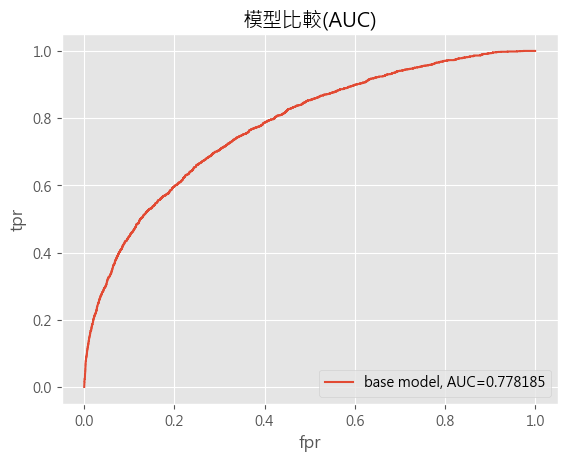

In [95]:
# plot ROC_AUC graph
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Microsoft Jhenghei']
plt.rcParams['axes.unicode_minus']=False
plt.figure(0).clf()
plt.style.use("ggplot")

plt.plot(fpr,tpr,label="base model, AUC="+str(round(auc,6)))


plt.legend(loc="lower right")
plt.title("模型比較(AUC)")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.savefig("modelAUCs.png")

### 影響因子重要性

In [96]:
fcolumns=['性別', '教育', '神智', '年齡', '每月採尿平均', '實際保管長度', '違規次數', '獎勵次數', '犯次',
       '一年內次數', '二年內次數', '三年內次數', '四年內次數', '五年內次數', '首犯年齡']

In [97]:
factImportance = pd.DataFrame({'feature':fcolumns,
                              'importance': model.feature_importances_}).sort_values('importance', ascending=False)

In [98]:
print(factImportance)

   feature  importance
4   每月採尿平均    0.173807
8       犯次    0.124531
5   實際保管長度    0.118738
2       神智    0.069121
12   四年內次數    0.066722
11   三年內次數    0.066288
13   五年內次數    0.061971
3       年齡    0.059554
1       教育    0.057938
10   二年內次數    0.054978
14    首犯年齡    0.041459
9    一年內次數    0.039690
7     獎勵次數    0.036923
0       性別    0.015880
6     違規次數    0.012399


### 計算混淆矩陣confusion matrix

In [99]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [100]:
cm #confusion matrix

array([[9267, 1476],
       [1125, 1213]], dtype=int64)

In [101]:
ftdf = pd.DataFrame({'fpr': fpr,
                       'tpr': tpr})

In [102]:
ftdf

,fpr,tpr
0,0.000000,0.000000
1,0.000000,0.000428
2,0.000000,0.000855
3,0.000093,0.000855
4,0.000093,0.003849
...,...,...
3409,0.996556,1.000000
3410,0.996742,1.000000
3411,0.997021,1.000000
3412,0.997301,1.000000


In [103]:
ftdf.to_csv("ftr_ptr_sub.csv", encoding="utf8")

In [104]:
results

,模型,AUC,準確率,精確率,招回率,f1_score,非再犯案例數,精確率.1,招回率.1,f1_score.1,再犯案例數
0,model1,0.778215,0.802156,0.891954,0.863725,0.877613,10743,0.453323,0.519247,0.484051,2338
1,model1,0.778185,0.801162,0.891744,0.862608,0.876934,10743,0.451097,0.518820,0.482594,2338


In [37]:
results.to_csv("output.csv", encoding="utf8")

In [38]:
!dir

 磁碟區 D 中的磁碟是 新增磁碟區
 磁碟區序號:  8EC2-0442

 D:\projects\mojp2023\src 的目錄

2023/08/25  下午 01:43    <DIR>          .
2023/07/31  下午 04:56    <DIR>          ..
2023/08/25  上午 10:48    <DIR>          .ipynb_checkpoints
2023/08/22  上午 10:45            42,101 drug_auc.png
2023/08/22  上午 10:47            45,646 fraud_auc.png
2023/08/25  下午 01:40           149,797 ftr_ptr.csv
2023/08/22  下午 03:13             4,920 hpt1.ipynb
2023/08/25  上午 10:45            83,101 hpt4model.ipynb
2023/08/25  下午 01:42            88,488 hpt4model1.ipynb
2023/08/21  下午 05:45            40,582 mcomp1.png
2023/08/24  下午 05:17            93,880 modelAnalysis1.ipynb
2023/08/25  下午 01:36            23,237 modelAUCs.png
2023/08/21  下午 05:38             2,634 modelcompare.py
2023/08/22  下午 05:36       140,618,247 modelfile.pkl
2023/08/25  下午 01:41               289 output.csv
2023/08/24  下午 12:49             6,260 output.xlsx
2023/08/22  下午 06:29           107,930 rfdrug_comparsion.ipynb
2023/08/22  上午 10:47            94,30